In [1]:
import copy
from core.datasets import FER13
import math
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models
%matplotlib inline

In [2]:
preprocess = transforms.Compose([
    transforms.RandomCrop(44),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

In [3]:
datasets = {
    x: FER13(
        root = "./data",
        train = True if x == "train" else False,
        transform = preprocess,
    )
    for x in ["train", "val"]
}

In [4]:
datasets["train"]

Dataset FER13
    Number of datapoints: 28709
    Root location: ./data
    Split: Train
    Compose(
    RandomCrop(size=(44, 44), padding=None)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)

In [5]:
datasets["val"]

Dataset FER13
    Number of datapoints: 3589
    Root location: ./data
    Split: Test
    Compose(
    RandomCrop(size=(44, 44), padding=None)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)

In [6]:
dataloaders = {
    x: DataLoader(
        datasets[x],
        batch_size=128,
        shuffle=False,
        num_workers=4
    )
    for x in ["train", "val"]
}
class_names = datasets["train"].classes
dataset_sizes = {
    x: len(datasets[x])
    for x in ["train", "val"]
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def imshow(inp, title=None):
    """ Imshow for Tensor """
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, cmap=plt.cm.gray)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

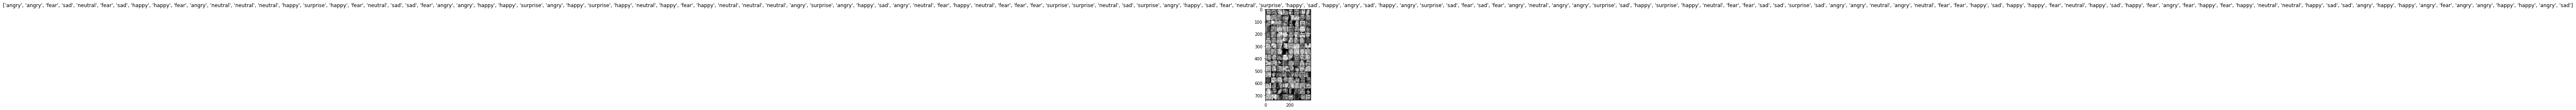

In [8]:
inputs, classes = next(iter(dataloaders["train"]))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                labels = labels.type(torch.LongTensor)

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
gray_model = models.resnet18(pretrained=True)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = gray_model.fc.in_features
gray_model.fc = nn.Linear(num_ftrs, len(class_names))

gray_model = gray_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(gray_model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
gray_model = train_model(
    gray_model,
    criterion,
    optimizer_conv,
    exp_lr_scheduler,
    num_epochs=1
)

Epoch 0/0
----------
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/eisti/anaconda3/envs/python3.8/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/eisti/anaconda3/envs/python3.8/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/eisti/anaconda3/envs/python3.8/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/eisti/anaconda3/envs/python3.8/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/eisti/anaconda3/envs/python3.8/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/eisti/anaconda3/envs/python3.8/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_byt

KeyboardInterrupt: 

In [16]:
visualize_model(gray_model)

TypeError: Invalid shape (44, 44, 1) for image data